<a href="https://colab.research.google.com/github/data2450/rosman-sales-prediciton/blob/main/reconstruction_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime

In [ ]:
tr=pd.read_csv('/content/drive/MyDrive/datasets_for_colab/dataset/TRAIN.csv')
test_1=pd.read_csv('/content/drive/MyDrive/datasets_for_colab/dataset/TEST.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
d=pd.read_csv('/content/drive/MyDrive/datasets_for_colab/dataset/store.csv')

In [ ]:
d["CompetitionDistance"].fillna(2325.0, inplace = True)

In [ ]:
d.fillna(0, inplace=True)

In [ ]:
d.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [ ]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  1115 non-null   float64
 5   CompetitionOpenSinceYear   1115 non-null   float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            1115 non-null   float64
 8   Promo2SinceYear            1115 non-null   float64
 9   PromoInterval              1115 non-null   object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [ ]:
tr.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
tr_remo=tr[(tr.Open != 0)&(tr.Sales >0)]

In [ ]:
def q90(x):
    return x.quantile(0.9)


def q25(x):
    return x.quantile(0.25)

def q01(x):
    return x.quantile(0.01)


In [ ]:
tr_remo.shape

(589948, 9)

In [ ]:
driven=tr_remo.groupby('Store').agg({'Sales':['mean','median','std',q90,q25,q01],'Customers':['mean','median','std',q90,q25,q01]})

In [ ]:
driven.head()

Sales                       ... Customers                  
              mean  median          std  ...       q90      q25      q01
Store                                    ...                            
1      4716.821300  4599.5  1047.665103  ...     667.7   493.00   408.18
2      5026.794964  4841.5  1652.606705  ...     776.5   498.00   301.10
3      6942.427536  6683.5  2209.212216  ...     946.0   659.75   401.55
4      9806.485612  9567.0  1972.395106  ...    1586.0  1185.00  1003.65
5      4720.068841  4637.0  1793.129421  ...     732.0   481.00   201.00

[5 rows x 12 columns]

In [ ]:
driven.reset_index(inplace=True)

In [ ]:
driven.columns=['Store','S_mean','S_median','S_std','S_q90','S_q25','S_q01','C_mean','C_medin','C_std','C_q90','C_q25','C_q01']

In [ ]:
driven.head()

,Store,S_mean,S_median,S_std,S_q90,S_q25,S_q01,C_mean,C_medin,C_std,C_q90,C_q25,C_q01
0,1,4716.821300,4599.5,1047.665103,6029.0,3919.25,3107.80,555.579422,542.0,96.259135,667.7,493.00,408.18
1,2,5026.794964,4841.5,1652.606705,7162.0,3891.25,2405.65,585.377698,573.5,156.094050,776.5,498.00,301.10
2,3,6942.427536,6683.5,2209.212216,9777.2,5217.50,3370.06,745.728261,742.0,171.080866,946.0,659.75,401.55
3,4,9806.485612,9567.0,1972.395106,12337.0,8444.00,6612.35,1332.697842,1310.0,200.071452,1586.0,1185.00,1003.65
4,5,4720.068841,4637.0,1793.129421,7210.1,3647.50,1699.02,537.784420,562.0,166.670520,732.0,481.00,201.00


In [ ]:
dat=['S_mean','S_median','S_std','S_q90','S_q25','S_q01','C_mean','C_medin','C_std','C_q90','C_q25','C_q01']

In [ ]:
driven[dat] = driven[dat].round(2)
driven.head()

,Store,S_mean,S_median,S_std,S_q90,S_q25,S_q01,C_mean,C_medin,C_std,C_q90,C_q25,C_q01
0,1,4716.82,4599.5,1047.67,6029.0,3919.25,3107.80,555.58,542.0,96.26,667.7,493.00,408.18
1,2,5026.79,4841.5,1652.61,7162.0,3891.25,2405.65,585.38,573.5,156.09,776.5,498.00,301.10
2,3,6942.43,6683.5,2209.21,9777.2,5217.50,3370.06,745.73,742.0,171.08,946.0,659.75,401.55
3,4,9806.49,9567.0,1972.40,12337.0,8444.00,6612.35,1332.70,1310.0,200.07,1586.0,1185.00,1003.65
4,5,4720.07,4637.0,1793.13,7210.1,3647.50,1699.02,537.78,562.0,166.67,732.0,481.00,201.00


In [ ]:
# merge data with store 
train = pd.merge(tr, d, on='Store')
test = pd.merge(test, d, on='Store')

# split the last 6 weeks data as hold-out set (idea from Gert https://www.kaggle.com/c/rossmann-store-sales/discussion/18024)
train = train.sort_values(['Date'],ascending = False)
train_total = train.copy()

split_index = 6*7*1115
valid = train[:split_index] 
train = train[split_index:]

# only use data of Sales>0 and Open is 1
valid = valid[(valid.Open != 0)&(valid.Sales >0)]
train = train[(train.Open != 0)&(train.Sales >0)]
train_total = train_total[(train_total.Open != 0)&(train_total.Sales >0)]

In [ ]:
valid.shape,train.shape,train_total.shape

((40282, 18), (549666, 18), (589948, 18))

In [ ]:
train_total["day"] = pd.to_datetime(train_total.Date, format="%Y/%m/%d").dt.day

train_total["month"] = pd.to_datetime(train_total.Date, format="%Y/%m/%d").dt.month

train_total["year"] = pd.to_datetime(train_total.Date, format="%Y/%m/%d").dt.year

train_total["WeekOfYear"] = pd.to_datetime(train_total.Date, format="%Y/%m/%d").dt.weekofyear


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


In [ ]:
train_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 589948 entries, 0 to 86266
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      589948 non-null  int64  
 1   DayOfWeek                  589948 non-null  int64  
 2   Date                       589948 non-null  object 
 3   Sales                      589948 non-null  int64  
 4   Customers                  589948 non-null  int64  
 5   Open                       589948 non-null  int64  
 6   Promo                      589948 non-null  int64  
 7   StateHoliday               589948 non-null  object 
 8   SchoolHoliday              589948 non-null  int64  
 9   StoreType                  589948 non-null  object 
 10  Assortment                 589948 non-null  object 
 11  CompetitionDistance        589948 non-null  float64
 12  CompetitionOpenSinceMonth  589948 non-null  float64
 13  CompetitionOpenSinceYear   589

In [ ]:
# competition open time (in months)
train_total['CompetitionOpen'] = 12 * (train_total.year - train_total.CompetitionOpenSinceYear) + \
        (train_total.month - train_total.CompetitionOpenSinceMonth)


In [ ]:
train_total['CompetitionOpen'] = train_total['CompetitionOpen'].apply(lambda x: x if x > 0 else 0)

In [ ]:
train_total['PromoOpen'] = 12 * (train_total.year - train_total.Promo2SinceYear) + \
        (train_total.WeekOfYear - train_total.Promo2SinceWeek) / 4.0

In [ ]:
train_total['PromoOpen'] = train_total['PromoOpen'].apply(lambda x: x if x > 0 else 0)

In [ ]:
train_total.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,day,month,year,WeekOfYear,CompetitionOpen,PromoOpen
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,31,7,2015,31,82.0,24187.75
43652,69,5,2015-07-31,11204,1371,1,1,0,1,c,c,1130.0,0.0,0.0,1,40.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015,31,24187.0,45.75
7359,12,5,2015-07-31,8959,962,1,1,0,1,a,c,1070.0,0.0,0.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",31,7,2015,31,24187.0,64.50
382814,600,5,2015-07-31,12377,898,1,1,0,1,d,c,17340.0,6.0,2010.0,1,9.0,2011.0,"Feb,May,Aug,Nov",31,7,2015,31,61.0,53.50
201100,317,5,2015-07-31,7374,683,1,1,0,0,d,a,3140.0,7.0,2013.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015,31,24.0,52.25


In [ ]:
train_total["StateHoliday"].replace(['0','a','b','c','d',0],[0,1,2,3,4,0],inplace = True)

In [ ]:
train_total.StoreType.unique()

array(['c', 'a', 'd', 'b'], dtype=object)

In [ ]:
train_total.Assortment.unique()

array(['a', 'c', 'b'], dtype=object)

In [ ]:
train_total.PromoInterval.unique()

array([0, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [ ]:
train_total["StoreType"].replace(['a','b','c','d'],[1,2,3,4],inplace = True)

In [ ]:
train_total["Assortment"].replace(['a','b','c','d'],[1,2,3,4],inplace = True)

In [ ]:
train_total["PromoInterval"].replace(['Jan,Apr,Jul,Oct','Feb,May,Aug,Nov','Mar,Jun,Sept,Dec',0],[1,2,3,0],inplace = True)

In [ ]:
train_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 589948 entries, 0 to 86266
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      589948 non-null  int64  
 1   DayOfWeek                  589948 non-null  int64  
 2   Date                       589948 non-null  object 
 3   Sales                      589948 non-null  int64  
 4   Customers                  589948 non-null  int64  
 5   Open                       589948 non-null  int64  
 6   Promo                      589948 non-null  int64  
 7   StateHoliday               589948 non-null  int64  
 8   SchoolHoliday              589948 non-null  int64  
 9   StoreType                  589948 non-null  int64  
 10  Assortment                 589948 non-null  int64  
 11  CompetitionDistance        589948 non-null  float64
 12  CompetitionOpenSinceMonth  589948 non-null  float64
 13  CompetitionOpenSinceYear   589

In [ ]:
train_total['Sales']=np.log1p(train_total['Sales'])

In [ ]:
train_total.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,day,month,year,WeekOfYear,CompetitionOpen,PromoOpen
count,589948.000000,589948.000000,589948.000000,589948.000000,589948.0,589948.000000,589948.000000,589948.000000,589948.000000,589948.000000,589948.000000,589948.000000,589948.000000,589948.000000,589948.000000,589948.000000,589948.000000,589948.000000,589948.000000,589948.000000,589948.000000,589948.000000,589948.000000
mean,558.357045,3.515945,8.777317,770.013186,1.0,0.446246,0.001512,0.184893,2.201396,1.939903,5457.223552,4.923141,1369.317396,0.493432,11.399812,992.660912,0.801227,15.889683,6.185162,2014.190686,25.050752,7740.193571,12262.026910
std,321.831778,1.724734,0.422715,403.964951,0.0,0.497103,0.050636,0.388211,1.361554,0.993231,7820.553808,4.283097,935.710373,0.499957,15.206944,1005.789567,0.983196,8.684561,3.536182,0.661451,15.302613,11231.577741,12072.142104
min,1.000000,1.000000,3.850148,8.000000,1.0,0.000000,0.000000,0.000000,1.000000,1.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2013.000000,1.000000,0.000000,0.000000
25%,280.000000,2.000000,8.509363,526.000000,1.0,0.000000,0.000000,0.000000,1.000000,1.000000,710.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,3.000000,2014.000000,12.000000,33.000000,30.750000
50%,558.000000,3.000000,8.777401,682.000000,1.0,0.000000,0.000000,0.000000,1.000000,1.000000,2325.000000,4.000000,2006.000000,0.000000,0.000000,0.000000,0.000000,16.000000,6.000000,2014.000000,24.000000,96.000000,24166.250000
75%,837.000000,5.000000,9.049232,899.000000,1.0,1.000000,0.000000,0.000000,4.000000,3.000000,6880.000000,9.000000,2011.000000,1.000000,18.000000,2012.000000,1.000000,23.000000,10.000000,2015.000000,40.000000,24170.000000,24177.000000
max,1115.000000,7.000000,10.634701,5494.000000,1.0,1.000000,3.000000,1.000000,4.000000,3.000000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000,3.000000,31.000000,12.000000,2015.000000,52.000000,24187.000000,24187.750000


In [ ]:
full_train=pd.merge(train_total, driven, on='Store')

In [ ]:
full_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 589948 entries, 0 to 589947
Data columns (total 36 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      589948 non-null  int64  
 1   DayOfWeek                  589948 non-null  int64  
 2   Date                       589948 non-null  object 
 3   Sales                      589948 non-null  float64
 4   Customers                  589948 non-null  int64  
 5   Open                       589948 non-null  int64  
 6   Promo                      589948 non-null  int64  
 7   StateHoliday               589948 non-null  int64  
 8   SchoolHoliday              589948 non-null  int64  
 9   StoreType                  589948 non-null  int64  
 10  Assortment                 589948 non-null  int64  
 11  CompetitionDistance        589948 non-null  float64
 12  CompetitionOpenSinceMonth  589948 non-null  float64
 13  CompetitionOpenSinceYear   58

In [ ]:
full_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,day,month,year,WeekOfYear,CompetitionOpen,PromoOpen,S_mean,S_median,S_std,S_q90,S_q25,S_q01,C_mean,C_medin,C_std,C_q90,C_q25,C_q01
0,1,5,2015-07-31,8.568646,555,1,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0,31,7,2015,31,82.0,24187.75,4716.82,4599.5,1047.67,6029.0,3919.25,3107.8,555.58,542.0,96.26,667.7,493.0,408.18
1,1,4,2015-07-30,8.521384,546,1,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0,30,7,2015,31,82.0,24187.75,4716.82,4599.5,1047.67,6029.0,3919.25,3107.8,555.58,542.0,96.26,667.7,493.0,408.18
2,1,3,2015-07-29,8.472823,523,1,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0,29,7,2015,31,82.0,24187.75,4716.82,4599.5,1047.67,6029.0,3919.25,3107.8,555.58,542.0,96.26,667.7,493.0,408.18
3,1,2,2015-07-28,8.519590,560,1,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0,28,7,2015,31,82.0,24187.75,4716.82,4599.5,1047.67,6029.0,3919.25,3107.8,555.58,542.0,96.26,667.7,493.0,408.18
4,1,1,2015-07-27,8.716536,612,1,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0,27,7,2015,31,82.0,24187.75,4716.82,4599.5,1047.67,6029.0,3919.25,3107.8,555.58,542.0,96.26,667.7,493.0,408.18


In [ ]:
train_new_on = full_train.sort_values(['Date'],ascending = False)
train_new_f = train_new_on.copy()

In [ ]:
train_new_f .info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 589948 entries, 0 to 589947
Data columns (total 36 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      589948 non-null  int64  
 1   DayOfWeek                  589948 non-null  int64  
 2   Date                       589948 non-null  object 
 3   Sales                      589948 non-null  float64
 4   Customers                  589948 non-null  int64  
 5   Open                       589948 non-null  int64  
 6   Promo                      589948 non-null  int64  
 7   StateHoliday               589948 non-null  int64  
 8   SchoolHoliday              589948 non-null  int64  
 9   StoreType                  589948 non-null  int64  
 10  Assortment                 589948 non-null  int64  
 11  CompetitionDistance        589948 non-null  float64
 12  CompetitionOpenSinceMonth  589948 non-null  float64
 13  CompetitionOpenSinceYear   58

# test

In [ ]:
t=pd.read_csv('/content/drive/MyDrive/datasets_for_colab/dataset/TEST.csv')

In [ ]:
t['index1'] = t.index

In [ ]:
test_Z=t.loc[t.Open==0]

In [ ]:
test = pd.merge(t, d, on='Store')

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305163 entries, 0 to 305162
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      305163 non-null  int64  
 1   DayOfWeek                  305163 non-null  int64  
 2   Date                       305163 non-null  object 
 3   Open                       305163 non-null  int64  
 4   Promo                      305163 non-null  int64  
 5   StateHoliday               305163 non-null  object 
 6   SchoolHoliday              305163 non-null  int64  
 7   index1                     305163 non-null  int64  
 8   StoreType                  305163 non-null  object 
 9   Assortment                 305163 non-null  object 
 10  CompetitionDistance        305163 non-null  float64
 11  CompetitionOpenSinceMonth  305163 non-null  float64
 12  CompetitionOpenSinceYear   305163 non-null  float64
 13  Promo2                     30

In [ ]:
test_on=test.loc[test.Open!=0]

In [ ]:
test_on.shape

(254409, 17)

In [ ]:
test_on["day"] = pd.to_datetime(test_on.Date, format="%Y/%m/%d").dt.day

test_on["month"] = pd.to_datetime(test_on.Date, format="%Y/%m/%d").dt.month

test_on["year"] = pd.to_datetime(test_on.Date, format="%Y/%m/%d").dt.year

test_on["WeekOfYear"] = pd.to_datetime(test_on.Date, format="%Y/%m/%d").dt.weekofyear

In [ ]:
test_on.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254409 entries, 1 to 305162
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      254409 non-null  int64  
 1   DayOfWeek                  254409 non-null  int64  
 2   Date                       254409 non-null  object 
 3   Open                       254409 non-null  int64  
 4   Promo                      254409 non-null  int64  
 5   StateHoliday               254409 non-null  object 
 6   SchoolHoliday              254409 non-null  int64  
 7   index1                     254409 non-null  int64  
 8   StoreType                  254409 non-null  object 
 9   Assortment                 254409 non-null  object 
 10  CompetitionDistance        254409 non-null  float64
 11  CompetitionOpenSinceMonth  254409 non-null  float64
 12  CompetitionOpenSinceYear   254409 non-null  float64
 13  Promo2                     25

In [ ]:
test_on['CompetitionOpen'] = 12 * (test_on.year - test_on.CompetitionOpenSinceYear) + \
        (test_on.month - test_on.CompetitionOpenSinceMonth)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test_on['CompetitionOpen'] = test_on['CompetitionOpen'].apply(lambda x: x if x > 0 else 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test_on['PromoOpen'] = 12 * (test_on.year - test_on.Promo2SinceYear) + \
        (test_on.WeekOfYear - test_on.Promo2SinceWeek) / 4.0

In [ ]:
test_on['PromoOpen'] = test_on['PromoOpen'].apply(lambda x: x if x > 0 else 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test_on.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254409 entries, 1 to 305162
Data columns (total 23 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      254409 non-null  int64  
 1   DayOfWeek                  254409 non-null  int64  
 2   Date                       254409 non-null  object 
 3   Open                       254409 non-null  int64  
 4   Promo                      254409 non-null  int64  
 5   StateHoliday               254409 non-null  object 
 6   SchoolHoliday              254409 non-null  int64  
 7   index1                     254409 non-null  int64  
 8   StoreType                  254409 non-null  object 
 9   Assortment                 254409 non-null  object 
 10  CompetitionDistance        254409 non-null  float64
 11  CompetitionOpenSinceMonth  254409 non-null  float64
 12  CompetitionOpenSinceYear   254409 non-null  float64
 13  Promo2                     25

In [ ]:
test_on.head()

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,index1,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,day,month,year,WeekOfYear,CompetitionOpen,PromoOpen
1,767,3,2013-08-07,1,0,0,0,16,a,c,13080.0,0.0,0.0,0,0.0,0.0,0,7,8,2013,32,24164.0,24164.00
3,767,6,2013-07-13,1,0,0,0,3582,a,c,13080.0,0.0,0.0,0,0.0,0.0,0,13,7,2013,28,24163.0,24163.00
7,767,6,2013-08-03,1,0,0,0,9772,a,c,13080.0,0.0,0.0,0,0.0,0.0,0,3,8,2013,31,24164.0,24163.75
8,767,1,2013-07-29,1,1,0,1,10006,a,c,13080.0,0.0,0.0,0,0.0,0.0,0,29,7,2013,31,24163.0,24163.75
9,767,5,2013-05-10,1,0,0,1,12614,a,c,13080.0,0.0,0.0,0,0.0,0.0,0,10,5,2013,19,24161.0,24160.75


In [ ]:
test_on["StateHoliday"].replace(['0','a','b','c','d',0],[0,1,2,3,4,0],inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
test_on["Assortment"].replace(['a','b','c','d'],[1,2,3,4],inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
test_on["PromoInterval"].replace(['Jan,Apr,Jul,Oct','Feb,May,Aug,Nov','Mar,Jun,Sept,Dec',0],[1,2,3,0],inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
test_on["StoreType"].replace(['a','b','c','d'],[1,2,3,4],inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
test_on=pd.merge(test_on,driven,on='Store')

In [ ]:
test_on.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254409 entries, 0 to 254408
Data columns (total 35 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      254409 non-null  int64  
 1   DayOfWeek                  254409 non-null  int64  
 2   Date                       254409 non-null  object 
 3   Open                       254409 non-null  int64  
 4   Promo                      254409 non-null  int64  
 5   StateHoliday               254409 non-null  int64  
 6   SchoolHoliday              254409 non-null  int64  
 7   index1                     254409 non-null  int64  
 8   StoreType                  254409 non-null  int64  
 9   Assortment                 254409 non-null  int64  
 10  CompetitionDistance        254409 non-null  float64
 11  CompetitionOpenSinceMonth  254409 non-null  float64
 12  CompetitionOpenSinceYear   254409 non-null  float64
 13  Promo2                     25

In [ ]:
test_on.head()

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,index1,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,day,month,year,WeekOfYear,CompetitionOpen,PromoOpen,S_mean,S_median,S_std,S_q90,S_q25,S_q01,C_mean,C_medin,C_std,C_q90,C_q25,C_q01
0,767,3,2013-08-07,1,0,0,0,16,1,3,13080.0,0.0,0.0,0,0.0,0.0,0,7,8,2013,32,24164.0,24164.00,6097.09,5986.0,1931.93,8817.2,4811.0,2697.42,615.48,622.0,158.22,796.6,542.5,291.54
1,767,6,2013-07-13,1,0,0,0,3582,1,3,13080.0,0.0,0.0,0,0.0,0.0,0,13,7,2013,28,24163.0,24163.00,6097.09,5986.0,1931.93,8817.2,4811.0,2697.42,615.48,622.0,158.22,796.6,542.5,291.54
2,767,6,2013-08-03,1,0,0,0,9772,1,3,13080.0,0.0,0.0,0,0.0,0.0,0,3,8,2013,31,24164.0,24163.75,6097.09,5986.0,1931.93,8817.2,4811.0,2697.42,615.48,622.0,158.22,796.6,542.5,291.54
3,767,1,2013-07-29,1,1,0,1,10006,1,3,13080.0,0.0,0.0,0,0.0,0.0,0,29,7,2013,31,24163.0,24163.75,6097.09,5986.0,1931.93,8817.2,4811.0,2697.42,615.48,622.0,158.22,796.6,542.5,291.54
4,767,5,2013-05-10,1,0,0,1,12614,1,3,13080.0,0.0,0.0,0,0.0,0.0,0,10,5,2013,19,24161.0,24160.75,6097.09,5986.0,1931.93,8817.2,4811.0,2697.42,615.48,622.0,158.22,796.6,542.5,291.54


# MODEL

In [ ]:
train_new_f.shape

(589948, 36)

In [ ]:
train_new_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 589948 entries, 0 to 589947
Data columns (total 36 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      589948 non-null  int64  
 1   DayOfWeek                  589948 non-null  int64  
 2   Date                       589948 non-null  object 
 3   Sales                      589948 non-null  float64
 4   Customers                  589948 non-null  int64  
 5   Open                       589948 non-null  int64  
 6   Promo                      589948 non-null  int64  
 7   StateHoliday               589948 non-null  int64  
 8   SchoolHoliday              589948 non-null  int64  
 9   StoreType                  589948 non-null  int64  
 10  Assortment                 589948 non-null  int64  
 11  CompetitionDistance        589948 non-null  float64
 12  CompetitionOpenSinceMonth  589948 non-null  float64
 13  CompetitionOpenSinceYear   58

In [ ]:
%cd "/content/drive/MyDrive/datasets_for_colab/dataset"
train_new_f.to_csv('train_versio2.csv', index =False)

/content/drive/MyDrive/datasets_for_colab/dataset


In [ ]:
X=train_new_f.drop(['Sales','Customers','Date','Open'],axis=1)

In [ ]:
X.shape

(589948, 32)

In [ ]:
train_new_f.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,day,month,year,WeekOfYear,CompetitionOpen,PromoOpen,S_mean,S_median,S_std,S_q90,S_q25,S_q01,C_mean,C_medin,C_std,C_q90,C_q25,C_q01
0,1,5,2015-07-31,8.568646,555,1,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0,31,7,2015,31,82.0,24187.75,4716.82,4599.5,1047.67,6029.0,3919.25,3107.80,555.58,542.0,96.26,667.7,493.00,408.18
436521,938,5,2015-07-31,9.414831,1139,1,1,0,1,1,1,2820.0,9.0,2009.0,0,0.0,0.0,0,31,7,2015,31,70.0,24187.75,9532.49,9098.0,1961.34,12616.0,8020.50,6780.30,971.75,937.0,142.63,1194.2,876.00,753.08
111140,282,5,2015-07-31,8.468423,608,1,1,0,1,1,1,1220.0,12.0,2010.0,0,0.0,0.0,0,31,7,2015,31,55.0,24187.75,4452.03,4339.0,1053.08,5837.0,3693.00,2541.20,639.86,646.0,111.32,779.0,580.75,392.70
439286,566,5,2015-07-31,8.882253,690,1,1,0,1,1,1,3620.0,0.0,0.0,1,40.0,2013.0,1,31,7,2015,31,24187.0,21.75,5144.32,4980.0,1293.88,6842.4,4159.00,3023.72,559.53,557.0,102.53,688.6,491.00,364.08
438731,300,5,2015-07-31,9.285912,1082,1,1,0,1,1,3,120.0,4.0,2009.0,1,1.0,2012.0,1,31,7,2015,31,75.0,43.50,7431.39,7235.0,1530.00,9392.2,6310.00,4792.18,915.30,906.0,130.54,1081.6,819.00,673.40


In [ ]:
X.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,day,month,year,WeekOfYear,CompetitionOpen,PromoOpen,S_mean,S_median,S_std,S_q90,S_q25,S_q01,C_mean,C_medin,C_std,C_q90,C_q25,C_q01
0,1,5,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0,31,7,2015,31,82.0,24187.75,4716.82,4599.5,1047.67,6029.0,3919.25,3107.80,555.58,542.0,96.26,667.7,493.00,408.18
436521,938,5,1,0,1,1,1,2820.0,9.0,2009.0,0,0.0,0.0,0,31,7,2015,31,70.0,24187.75,9532.49,9098.0,1961.34,12616.0,8020.50,6780.30,971.75,937.0,142.63,1194.2,876.00,753.08
111140,282,5,1,0,1,1,1,1220.0,12.0,2010.0,0,0.0,0.0,0,31,7,2015,31,55.0,24187.75,4452.03,4339.0,1053.08,5837.0,3693.00,2541.20,639.86,646.0,111.32,779.0,580.75,392.70
439286,566,5,1,0,1,1,1,3620.0,0.0,0.0,1,40.0,2013.0,1,31,7,2015,31,24187.0,21.75,5144.32,4980.0,1293.88,6842.4,4159.00,3023.72,559.53,557.0,102.53,688.6,491.00,364.08
438731,300,5,1,0,1,1,3,120.0,4.0,2009.0,1,1.0,2012.0,1,31,7,2015,31,75.0,43.50,7431.39,7235.0,1530.00,9392.2,6310.00,4792.18,915.30,906.0,130.54,1081.6,819.00,673.40


In [ ]:
y=train_new_f.Sales

In [ ]:
y

0         8.568646
436521    9.414831
111140    8.468423
439286    8.882253
438731    9.285912
            ...   
37142     8.942984
202949    8.304495
111139    9.032768
285154    8.651374
589947    8.572817
Name: Sales, Length: 589948, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

**tse**

In [ ]:
test_on.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254409 entries, 0 to 254408
Data columns (total 35 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      254409 non-null  int64  
 1   DayOfWeek                  254409 non-null  int64  
 2   Date                       254409 non-null  object 
 3   Open                       254409 non-null  int64  
 4   Promo                      254409 non-null  int64  
 5   StateHoliday               254409 non-null  int64  
 6   SchoolHoliday              254409 non-null  int64  
 7   index1                     254409 non-null  int64  
 8   StoreType                  254409 non-null  int64  
 9   Assortment                 254409 non-null  int64  
 10  CompetitionDistance        254409 non-null  float64
 11  CompetitionOpenSinceMonth  254409 non-null  float64
 12  CompetitionOpenSinceYear   254409 non-null  float64
 13  Promo2                     25

In [ ]:
re_ts=test_on.drop(['Date','Open'],axis=1)

In [ ]:
%cd "/content/drive/MyDrive/datasets_for_colab/dataset"
re_ts.to_csv('test_versio2.csv', index =False)

/content/drive/MyDrive/datasets_for_colab/dataset


In [ ]:
re_ts.shape

(254409, 33)

In [ ]:
full_test=re_ts.sort_values(by='index1',ascending=True)

In [ ]:
full_test.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,index1,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,day,month,year,WeekOfYear,CompetitionOpen,PromoOpen,S_mean,S_median,S_std,S_q90,S_q25,S_q01,C_mean,C_medin,C_std,C_q90,C_q25,C_q01
229,1111,6,0,0,0,1,1,1,1900.0,6.0,2014.0,1,31.0,2013.0,1,16,3,2013,11,0.0,0.00,5238.02,5031.0,1715.75,7644.0,3983.50,2516.00,442.44,446.0,117.21,592.0,371.5,213.00
457,45,4,1,0,1,2,4,1,9710.0,2.0,2014.0,0,0.0,0.0,0,1,8,2013,31,0.0,24163.75,5338.30,5301.0,1360.32,7152.5,4327.25,3099.28,412.86,410.0,82.21,501.9,352.0,268.55
684,500,4,0,0,1,3,4,3,10690.0,9.0,2007.0,1,5.0,2013.0,1,23,5,2013,21,68.0,4.00,5793.70,5711.0,1060.59,7267.2,5035.50,3827.70,419.27,410.0,64.79,505.0,372.5,314.58
911,82,2,0,0,1,4,1,1,22390.0,4.0,2008.0,1,37.0,2009.0,1,6,8,2013,32,64.0,46.75,9211.34,8910.0,2874.26,12997.8,6961.75,4794.02,852.56,861.0,202.71,1085.8,745.5,473.08
1367,1022,5,1,0,0,6,1,3,1520.0,0.0,0.0,0,0.0,0.0,0,22,3,2013,12,24159.0,24159.00,7602.22,7025.0,2177.86,10659.0,5962.50,4727.50,839.82,807.0,153.68,1075.0,728.0,596.50


In [ ]:
full_test_no=full_test.drop(['index1'],axis=1)

In [ ]:
full_test_no.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,day,month,year,WeekOfYear,CompetitionOpen,PromoOpen,S_mean,S_median,S_std,S_q90,S_q25,S_q01,C_mean,C_medin,C_std,C_q90,C_q25,C_q01
229,1111,6,0,0,0,1,1,1900.0,6.0,2014.0,1,31.0,2013.0,1,16,3,2013,11,0.0,0.00,5238.02,5031.0,1715.75,7644.0,3983.50,2516.00,442.44,446.0,117.21,592.0,371.5,213.00
457,45,4,1,0,1,4,1,9710.0,2.0,2014.0,0,0.0,0.0,0,1,8,2013,31,0.0,24163.75,5338.30,5301.0,1360.32,7152.5,4327.25,3099.28,412.86,410.0,82.21,501.9,352.0,268.55
684,500,4,0,0,1,4,3,10690.0,9.0,2007.0,1,5.0,2013.0,1,23,5,2013,21,68.0,4.00,5793.70,5711.0,1060.59,7267.2,5035.50,3827.70,419.27,410.0,64.79,505.0,372.5,314.58
911,82,2,0,0,1,1,1,22390.0,4.0,2008.0,1,37.0,2009.0,1,6,8,2013,32,64.0,46.75,9211.34,8910.0,2874.26,12997.8,6961.75,4794.02,852.56,861.0,202.71,1085.8,745.5,473.08
1367,1022,5,1,0,0,1,3,1520.0,0.0,0.0,0,0.0,0.0,0,22,3,2013,12,24159.0,24159.00,7602.22,7025.0,2177.86,10659.0,5962.50,4727.50,839.82,807.0,153.68,1075.0,728.0,596.50


In [ ]:
full_test_no.shape

(254409, 32)

In [ ]:
from sklearn.metrics import mean_squared_log_error
from math import sqrt

In [ ]:
import lightgbm as lgb
train_data = lgb.Dataset(X, label=y)
test_data = lgb.Dataset(X_test, label=y_test)

param = {'objective': 'regression',
         'boosting': 'gbdt',  
         'metric': 'l2_root',
         'learning_rate': 0.1, 
         'num_iterations': 3000,
         'num_leaves': 69,
         'max_depth': -1,
         'min_data_in_leaf': 11,
         'bagging_fraction': 0.90,
         'bagging_freq': 1,
         'bagging_seed': 3,
         'feature_fraction': 0.90,
         'feature_fraction_seed': 2,
         'early_stopping_round': 200,
         'max_bin': 1000
         }

lgbm = lgb.train(params=param, verbose_eval=100, train_set=train_data, valid_sets=[test_data])

y_pred_lgbm = lgbm.predict(X_test)
print('RMSE:', (mean_squared_log_error(np.expm1(y_test), np.expm1(y_pred_lgbm))))

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmse: 0.113722
[200]	valid_0's rmse: 0.104263
[300]	valid_0's rmse: 0.0986944
[400]	valid_0's rmse: 0.0949467
[500]	valid_0's rmse: 0.0919312
[600]	valid_0's rmse: 0.0896386
[700]	valid_0's rmse: 0.087729
[800]	valid_0's rmse: 0.0860682
[900]	valid_0's rmse: 0.084644
[1000]	valid_0's rmse: 0.0833712
[1100]	valid_0's rmse: 0.0821102
[1200]	valid_0's rmse: 0.0809925
[1300]	valid_0's rmse: 0.0800055
[1400]	valid_0's rmse: 0.0791207
[1500]	valid_0's rmse: 0.078295
[1600]	valid_0's rmse: 0.0775057
[1700]	valid_0's rmse: 0.0768346
[1800]	valid_0's rmse: 0.0760719
[1900]	valid_0's rmse: 0.0754037
[2000]	valid_0's rmse: 0.0747298
[2100]	valid_0's rmse: 0.074112
[2200]	valid_0's rmse: 0.0735361
[2300]	valid_0's rmse: 0.0729794
[2400]	valid_0's rmse: 0.0724501
[2500]	valid_0's rmse: 0.0719206
[2600]	valid_0's rmse: 0.0714063
[2700]	valid_0's rmse: 0.070852
[2800]	valid_0's rmse: 0.0703786
[2900]	valid_0's rmse: 0.0699

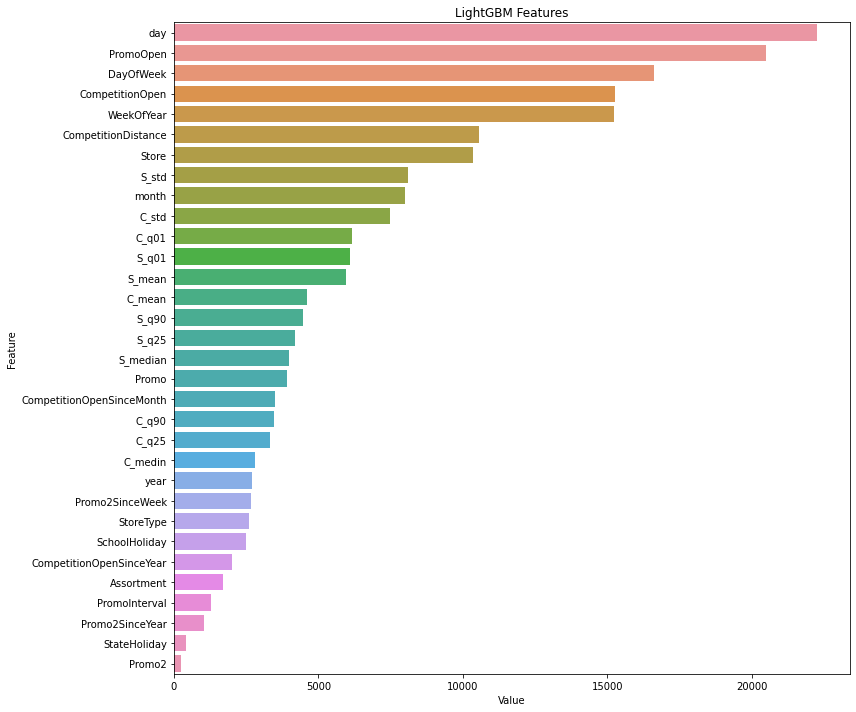

In [ ]:

import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importance(), X.columns), reverse=True)[:50], 
                           columns=['Value','Feature'])
plt.figure(figsize=(12, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [ ]:
y_pred_lgbm_t = lgbm.predict(full_test_no)

In [ ]:
y_lg=np.expm1(y_pred_lgbm_t).round(0)

In [ ]:
#y_lg

array([3371., 6543., 4241., ..., 3822., 2667., 5916.])

In [ ]:
y_lg

array([3415., 6649., 4182., ..., 3831., 2741., 6095.])

In [ ]:
final_data1 = {'Index ': full_test.index1, 'Response':y_lg }
submission7 = pd.DataFrame(data=final_data1)

In [ ]:
final_data1 = {'Index ':test_Z.index1, 'Response':0 }
submission_od = pd.DataFrame(data=final_data1)

In [ ]:
df_row = pd.concat([submission7, submission_od])

In [ ]:
df_row=df_row.sort_values(by=['Index '],ascending=True)

In [ ]:
df_row.head()

,Index,Response
0,0,0.0
229,1,3415.0
457,2,6649.0
684,3,4182.0
911,4,7415.0


In [ ]:
%cd "/content"
df_row.to_csv('power_on.csv', index =False)

/content


# big_lgb

In [ ]:
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor

errlgb = []
y_pred_totlgb = []

fold = KFold(n_splits=10, shuffle=True, random_state=101)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lgbm = LGBMRegressor(**param)
    lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=200)

    y_pred_lgbm = lgbm.predict(X_test)
    print("RMSLE LGBM: ", sqrt(mean_squared_log_error(np.exp(y_test), np.exp(y_pred_lgbm))))

    errlgb.append(sqrt(mean_squared_log_error(np.exp(y_test), np.exp(y_pred_lgbm))))
    p = lgbm.predict(full_test_no)
    y_pred_totlgb.append(p)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.08449680987041665


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.08421927291240262


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.08384719543923935


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.08557580872606528


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.0830544130716481


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.08444941858858097


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.08295962778710021


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.08432910144517036


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.08348998172766162


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.08583164199069938


In [ ]:
np.mean(errlgb,0)

In [ ]:
lgbm_final = np.expm1(np.mean(y_pred_totlgb,0))
lgbm_final

array([3565.88667338, 6429.89683331, 4097.71169882, ..., 3799.74525326,
       2663.42658767, 5823.49967028])

In [ ]:
final_data1 = {'Index ': full_test.index1, 'Response':lgbm_final }
submission7 = pd.DataFrame(data=final_data1)

In [ ]:
lgb_f = pd.concat([submission7, submission_od])

In [ ]:
lgb_f=lgb_f.sort_values(by=['Index '],ascending=True)

In [ ]:
lgb_f

,Index,Response
0,0,0.000000
229,1,3565.886673
457,2,6429.896833
684,3,4097.711699
911,4,7399.017531
...,...,...
81273,305158,10492.664997
187968,305159,7078.652706
110443,305160,3799.745253
63033,305161,2663.426588


In [ ]:
%cd "/content"
lgb_f.to_csv('fine_in.csv', index =False)

/content
